In [2]:
from COSIpy import *
import response
from fit import fit
plt.style.use('thomas')

In [3]:
plt.style.use('thomas')

In [4]:
#data_dir = 'data'
#filename = 'test_dataset_9det_CE0000-1000keV_EHCstandard.tra.gz'
#filename = 'SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz'

data_dir = '/Users/thomassiegert/data/COSI/Simulations/clio/from_cronus/'
filename = 'CrabOnly_CE_0000-5000keV.tra'

In [5]:
analysis = COSIpy(data_dir,filename)

In [6]:
analysis.read_COSI_DataSet()

Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFile!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFileEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFileEventsTra!


In [7]:
analysis.dataset.time_binning_tags(time_bin_size=3600)

In [8]:
energy_bin_edges=np.array([150,325,506,516,650,825,1000])
energy_bin_edges=np.array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350])#, 3450, 5000])
#energy_bin_edges=np.array([506,516])
#energy_bin_edges=np.arange(156,996,10)
#energy_bin_edges = np.logspace(2,3,7)
#energy_bin_edges = np.logspace(2,3,12)

In [9]:
energy_bin_edges

array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350])

In [10]:
analysis.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                              pixel_size=6.)

In [11]:
analysis.dataset.get_binned_data()

In [12]:
pointing = Pointing(dataset=analysis.dataset)

In [13]:
"""tracer = content['tracer']
trac = content['trac']
tracer12 = (tracer[::2] + tracer[1::2])/2"""

"tracer = content['tracer']\ntrac = content['trac']\ntracer12 = (tracer[::2] + tracer[1::2])/2"

In [14]:
"""PE_dir = 'data'
PE_filename = 'test_dataset_9det_PE0000-1000keV_EHCstandard.tra.gz'
    
try:
    with np.load('tracer.npz') as content:
        tracer = content['tracer']
        trac = content['trac']
except:
    print('File tracer.npz not found, reading in PE events now ...')
    pe_data = COSIpy(PE_dir,PE_filename)
    pe_data.read_COSI_DataSet()"""

"PE_dir = 'data'\nPE_filename = 'test_dataset_9det_PE0000-1000keV_EHCstandard.tra.gz'\n    \ntry:\n    with np.load('tracer.npz') as content:\n        tracer = content['tracer']\n        trac = content['trac']\nexcept:\n    print('File tracer.npz not found, reading in PE events now ...')\n    pe_data = COSIpy(PE_dir,PE_filename)\n    pe_data.read_COSI_DataSet()"

In [15]:
"""try:
    # histogramming PE data
    # note comment about time binning in BG case below:
    # to get the same time basis, we shift the pe_data time tags to the data set's
    trac = np.histogram(pe_data.dataset.data['TimeTags']-analysis.dataset.data['TimeTags'].min(),
                        bins=analysis.dataset.times.times_edges)

    # normalising tracer to show variation around 1.0
    tracer = trac[0]/np.mean(trac[0])

    # save tracer to file
    np.savez_compressed('tracer.npz',
                        tracer=tracer,
                        trac=trac)
except:
    print('Stuff already done')"""

"try:\n    # histogramming PE data\n    # note comment about time binning in BG case below:\n    # to get the same time basis, we shift the pe_data time tags to the data set's\n    trac = np.histogram(pe_data.dataset.data['TimeTags']-analysis.dataset.data['TimeTags'].min(),\n                        bins=analysis.dataset.times.times_edges)\n\n    # normalising tracer to show variation around 1.0\n    tracer = trac[0]/np.mean(trac[0])\n\n    # save tracer to file\n    np.savez_compressed('tracer.npz',\n                        tracer=tracer,\n                        trac=trac)\nexcept:\n    print('Stuff already done')"

In [16]:
with np.load('/Users/thomassiegert/python/COSIpy/COSIpy/tracer.npz',allow_pickle=True) as content:
    tracer = content['tracer']
    trac = content['trac']

In [17]:
tracer.shape

(24,)

In [18]:
tracer

array([0.65410243, 0.67385153, 0.71441512, 0.78155742, 0.94248122,
       1.19949406, 1.51705686, 1.79649855, 1.95832489, 1.91313224,
       1.72878866, 1.42036767, 1.07397908, 0.90930086, 0.77281106,
       0.7213936 , 0.68377958, 0.66407235, 0.65517246, 0.6544467 ,
       0.65349762, 0.65029218, 0.64985486, 0.61132898])

In [19]:
background = BG(dataset=analysis.dataset,mode='default 6deg')

Reading in flight-average background response for 6 deg CDS binning ...


In [20]:
background.bg_response.shape

(8, 30, 1145)

In [21]:
#background.make_bg_cuts([1,3,5,7,9,11,13,15,17,19,21,23,25])
#background.make_bg_cuts(list(np.arange(24)+1))

In [22]:
background.bg_cuts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
background.tracer

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

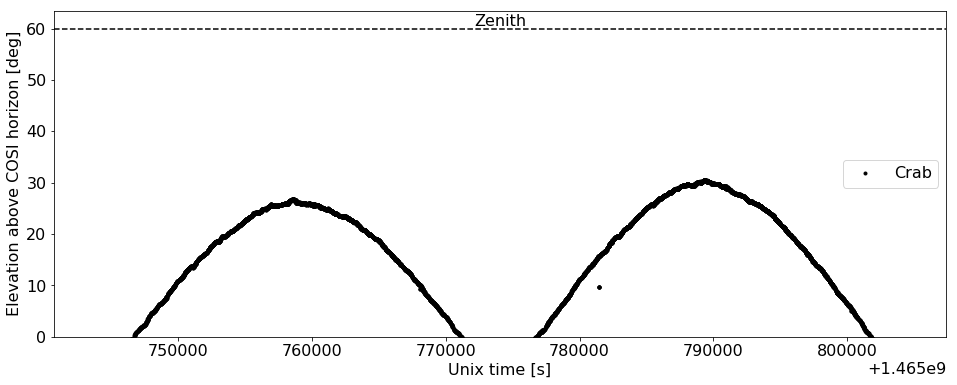

In [24]:
analysis.plot_elevation([-176],[-5],['Crab'])

In [25]:
import response

In [26]:
rsp = response.SkyResponse(filename='response/RegularResponseGrid_Continuum_10bins_v1.npz',pixel_size=6)

In [104]:
rsp2 = response.SkyResponse(filename='response/RegularResponseGrid_v1.npz',pixel_size=5)

In [27]:
analysis.dataset.energies.energy_bin_cen

array([ 185. ,  272.5,  402.5,  500. ,  642.5,  942.5, 1385. , 2000. ])

In [28]:
rsp.calculate_PS_response(analysis.dataset,
                          pointing,184.56-360,-5.78,1e-2,
                          background=background,
                          pixel_size=6.)

(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 988)
(30, 60, 988) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 1953)
(30, 60, 1953) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2525)
(30, 60, 2525) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2561)
(30, 60, 2561) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3037)
(30, 60, 3037) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3203)
(30, 60, 3203) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3559)
(30, 60, 3559) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3535)
(30, 60, 3535) 3


In [29]:
rsp.rsp.response_grid_normed.shape

(30, 60, 30, 1145, 10, 10)

In [30]:
from fit import fit

In [31]:
result = fit(analysis.dataset,
             pointing,
             rsp,
             background,
             priors=np.array([[1e4,1e8],[0,0.0001]]),
             verbose=True)

In [32]:
if np.any(np.array([[1e4,1e8],[0,0.1]]) == None):
    print(1)

In [33]:
result.MAP_solution()

Start optimising energy bin 1/8...

Energy range: 150-220 keV ...
Start optimising energy bin 2/8...

Energy range: 220-325 keV ...
Start optimising energy bin 3/8...

Energy range: 325-480 keV ...
Start optimising energy bin 4/8...

Energy range: 480-520 keV ...
Start optimising energy bin 5/8...

Energy range: 520-765 keV ...
Start optimising energy bin 6/8...

Energy range: 765-1120 keV ...
Start optimising energy bin 7/8...

Energy range: 1120-1650 keV ...
Start optimising energy bin 8/8...

Energy range: 1650-2350 keV ...

Initial log joint probability = -5.00017e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       8      -3004.49    0.00104477    0.00312152           1           1       24   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.00067e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

In [34]:
result.diff_flux_map

array([3.66720857e-01, 1.40959535e-01, 3.53818548e-02, 8.08539727e-02,
       6.57033789e-03, 1.71244976e-03, 4.06433850e-04, 9.27378404e-05])

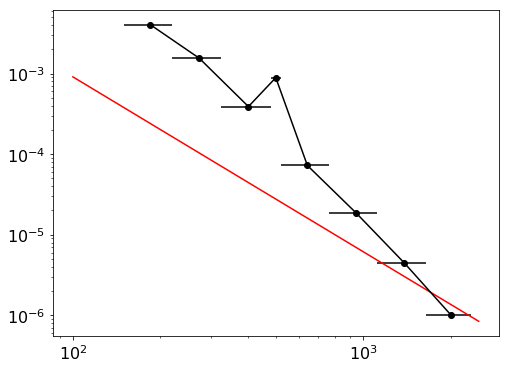

In [35]:
plt.errorbar(analysis.dataset.energies.energy_bin_cen,
             result.diff_flux_map*0.011,#/analysis.dataset.energies.energy_bin_wid/2,
             xerr=analysis.dataset.energies.energy_bin_wid,
             yerr=np.repeat(0,len(analysis.dataset.energies.energy_bin_cen)),fmt='o-')

plt.xscale('log')
plt.yscale('log')

x = np.logspace(2,np.log10(2500),100)
plt.plot(x,9.1e-4*(x/100)**(-2.17))

In [36]:
result.fit(iters=100,pars=['Abg','flux','model_values','model_sky','model_bg','model_tot'])

###################################################################

Start fitting energy bin 1/8...

Energy range: 150-220 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 1/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 2532.3   13.12 120.04 2299.4 2460.1 2543.6 2616.8 2733.3     84    1.0
Abg[1]  9.0e-4  9.6e-6 5.9e-5 7.9e-4 8.5e-4 8.9e-4 9.5e-4 1.0e-3     38   1.05

Samples were drawn using NUTS at Sun Nov 22 22:28:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 2/8...

Energy range: 220-325 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 2/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 1456.3    7.82  34.87 1379.9 1429.0 1463.4 1482.7 1513.5     20   0.98
Abg[1]  1.1e-3  2.3e-5 6.4e-5 1.0e-3 1.1e-3 1.1e-3 1.1e-3 1.2e-3      8   1.43

Samples were drawn using NUTS at Sun Nov 22 22:28:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 3/8...

Energy range: 325-480 keV ...
Summary for energy bin 3/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 538.98    1.52   11.2 519.69 530.52 537.74 549.06 558.84     55   1.04
Abg[1]  1.2e-3  2.1e-5 6.9e-5 1.0e-3 1.1e-3 1.2e-3 1.2e-3 1.3e-3     11   1.11

Samples were drawn using NUTS at Sun Nov 22 22:28:33 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 4/8...

Energy range: 480-520 keV ...
Summary for energy bin 4/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 318.56    3.27  16.19 283.41 306.92  317.5 333.15  342.2     24   0.99
Abg[1]  7.2e-4  1.3e-5 6.4e-5 5.9e-4 6.8e-4 7.3e-4 7.6e-4 8.3e-4     24   1.14

Samples were drawn using NUTS at Sun Nov 22 22:28:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
#############################################################

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 5/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 159.21     0.5   4.13 151.57 156.47 158.24 162.24 167.99     68   0.99
Abg[1]  7.6e-4  1.4e-5 5.6e-5 6.4e-4 7.4e-4 7.7e-4 8.0e-4 8.9e-4     17   1.16

Samples were drawn using NUTS at Sun Nov 22 22:28:44 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 6/8...

Energy range: 765-1120 keV ...
Summary for energy bin 6/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  59.92    0.34   2.29  55.23  58.37  59.54  61.57  63.93     44   0.99
Abg[1]  5.6e-4  1.3e-5 5.7e-5 4.8e-4 5.1e-4 5.6e-4 6.0e-4 6.8e-4     21   0.99

Samples were drawn using NUTS at Sun Nov 22 22:28:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 7/8...

Energy range: 1120-1650 keV ...
Summary for energy bin 7/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  21.57    0.06   0.68  20.23  21.04  21.64  22.07  22.77    131   0.99
Abg[1]  4.8e-4  1.3e-5 5.9e-5 3.6e-4 4.4e-4 4.8e-4 5.1e-4 6.0e-4     21    1.0

Samples were drawn using NUTS at Sun Nov 22 22:28:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###########################################################

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 8/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]   6.58    0.13   0.54   5.51   6.24   6.58   7.01   7.76     18   1.02
Abg[1]  2.9e-4  1.1e-5 4.8e-5 1.9e-4 2.5e-4 2.8e-4 3.2e-4 3.9e-4     21   0.98

Samples were drawn using NUTS at Sun Nov 22 22:29:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################


Gradient evaluation took 0.001631 seconds
1000 transitions using 10 leapfrog steps per transition would take 16.31 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

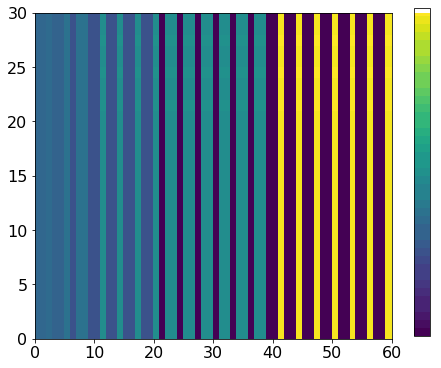

In [37]:
plt.pcolormesh(np.cos(rsp.dB_ARR)*rsp.dL_ARR)
plt.colorbar()

In [38]:
sky_filename = filename#'SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz'
sky_data = COSIpy(data_dir,sky_filename)
sky_data.read_COSI_DataSet()
sky_data.dataset.time_binning_tags(time_bin_size=1e5)
sky_data.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                             pixel_size=6.)
sky_data.dataset.get_binned_data()

In [39]:
sky_data.dataset.binned_data.shape

(1, 8, 30, 1145)

"for i in range(analysis.dataset.energies.n_energy_bins-1):\n    plt.plot([analysis.dataset.energies.energy_bin_min[i],\n              analysis.dataset.energies.energy_bin_min[i+1]],\n             np.repeat(plaw_folded_counts[i],2),'r-')\n    if ((i >= 0) & (i<rsp.n_e-1)):\n        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),\n                 [plaw_folded_counts[i],\n                  plaw_folded_counts[i+1]],'r-')\n        "

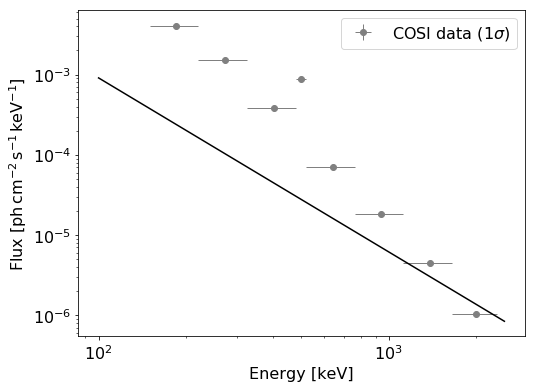

In [41]:
fig, ax = plt.subplots()

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:]*0.011,#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err[0:,:].T)*0.011,#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($1\sigma$)')


ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

#ax.axhline(0,linestyle=':')

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(0,1e-1)
ax.legend()

x = np.logspace(2,np.log10(2500),100)
plt.plot(x,9.1e-4*(x/100)**(-2.17))

"""for i in range(analysis.dataset.energies.n_energy_bins-1):
    plt.plot([analysis.dataset.energies.energy_bin_min[i],
              analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(plaw_folded_counts[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [plaw_folded_counts[i],
                  plaw_folded_counts[i+1]],'r-')
        """

In [ ]:
break

In [55]:
result.diff_flux[0:]/plaw_folded_counts[0:-2]

NameError: name 'plaw_folded_counts' is not defined

In [56]:
blub = np.array([rsp.sky_response[i].shape[1] for i in range(8)])

In [57]:
blub

array([ 988, 1953, 2525, 2561, 3037, 3203, 3559, 3535])

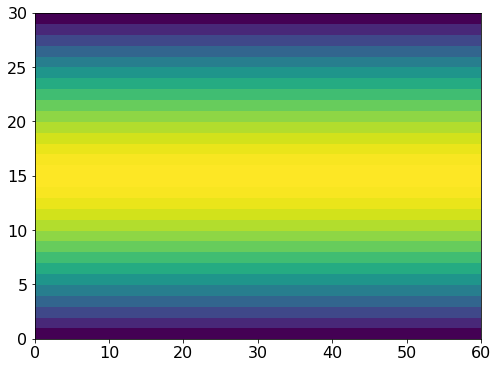

In [58]:
plt.pcolormesh(rsp.dOmega)

In [59]:
def powerlaw(energy, p):
    """
    Returns:
    Differential flux shaped as power-law function "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (in ph/cm2/s/keV)
    :param p:      p[1] = Power-law index (unitless)

    Misc:
    E0             Pivotal energy, i.e. where the power-law is normalised at (in keV)
    """
    
    E0 = 100.
    
    return p[0]*np.power(energy/E0,p[1])

In [60]:
def integrate_powerlaw(e_lo,e_hi,p):
    return (e_hi-e_lo)/6.0*(powerlaw(e_lo,p)+4*powerlaw((e_hi+e_lo)/2.0,p)+powerlaw(e_hi,p))

In [233]:
plaw_true_fluxes = integrate_powerlaw(rsp.e_min, rsp.e_max, (9.1e-4,-2.169))  # dNp/(dt dA) 

In [234]:
plaw_true_fluxes

array([0.01750875, 0.01135672, 0.00719357, 0.0011113 , 0.00411951,
       0.0025971 , 0.00168488, 0.00099547, 0.0007034 , 0.00043692])

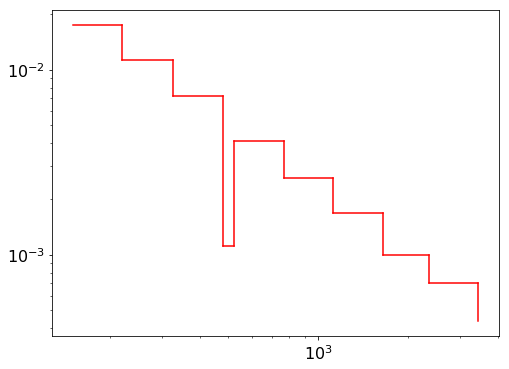

In [235]:
for i in range(rsp.n_e-1):
    plt.plot([rsp.e_min[i],
              rsp.e_min[i+1]],
             np.repeat(plaw_true_fluxes[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_true_fluxes[i],
                  plaw_true_fluxes[i+1]],'r-')
        
plt.xscale('log')
plt.yscale('log')

In [119]:
tmp = np.sum(rsp.rsp.response_grid_normed[9,30,:,:,:,:],axis=(0,1))

In [120]:
rsp.rsp.response_grid_normed.shape

(30, 60, 30, 1145, 10, 10)

In [249]:
plaw_folded_counts = 0

for i in tqdm(range(30)):
    for j in range(1145):
        plaw_folded_counts += np.dot(plaw_true_fluxes, rsp.rsp.response_grid_normed[0,0,i,j,:,:])
        
plaw_folded_counts /= rsp.e_wid*0.011

In [255]:
bla = [np.sum(rsp.sky_response[i]) for i in range (rsp.n_e-2)]

In [277]:
bla*plaw_true_fluxes[0:-2]

array([0.0023222 , 0.01601725, 0.03391701, 0.00146379, 0.04647324,
       0.04883017, 0.05357894, 0.03204935])

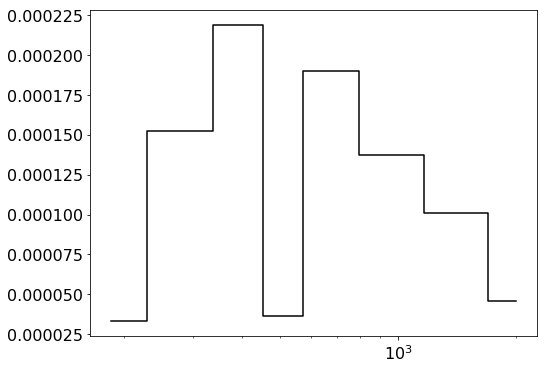

In [297]:
plt.step(rsp.e_cen[0:-2],bla*plaw_true_fluxes[0:-2]/rsp.e_wid[0:-2],where='mid')
plt.xscale('log')

In [298]:
response

<module 'response' from '/Users/thomassiegert/python/COSIpy/COSIpy/response.py'>

In [132]:
plaw_folded_counts = np.dot(plaw_true_fluxes, tmp/np.mean(np.diag(tmp)))/ rsp.e_wid

In [283]:
plaw_folded_counts = bla*plaw_true_fluxes[0:-2]/rsp.e_wid[0:-2]**2#bla/rsp.e_wid[0:-2]*rsp.e_cen[0:-2]**(-2.17)/np.mean(rsp.e_cen[0:-2]**(-2.17)*0.011)

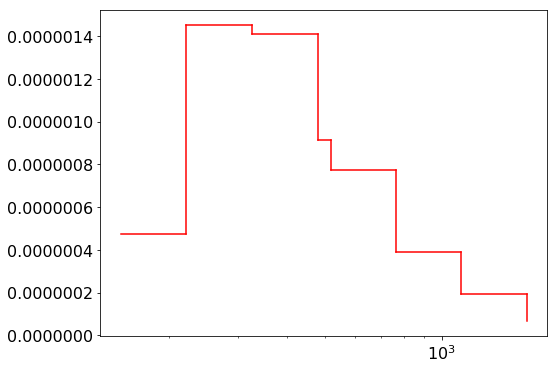

In [284]:
fac = 1#sky_data.dataset.times.times_wid

for i in range(rsp.n_e-3):
    plt.plot([rsp.e_min[i],
              rsp.e_min[i+1]],
             np.repeat(plaw_folded_counts[i],2)*fac,'r-')
    if ((i >= 0) & (i<rsp.n_e-3)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts[i]*fac,
                  plaw_folded_counts[i+1]*fac],'r-')
        

plt.xscale('log')
#plt.yscale('log')

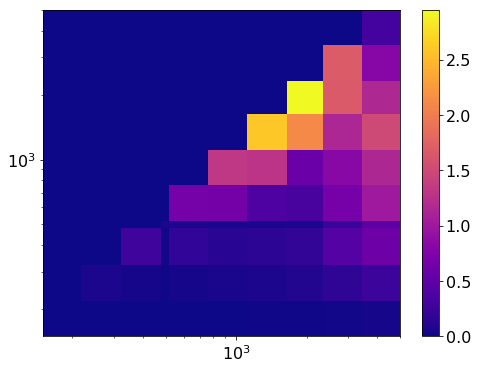

In [219]:
plt.pcolormesh(rsp.e_edges,rsp.e_edges,tmp.T/np.mean(np.diag(tmp)),
              cmap=plt.cm.plasma)#,vmin=0.9,vmax=1.1)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
#plt.xlim(100,5000)
#plt.ylim(100,5000)

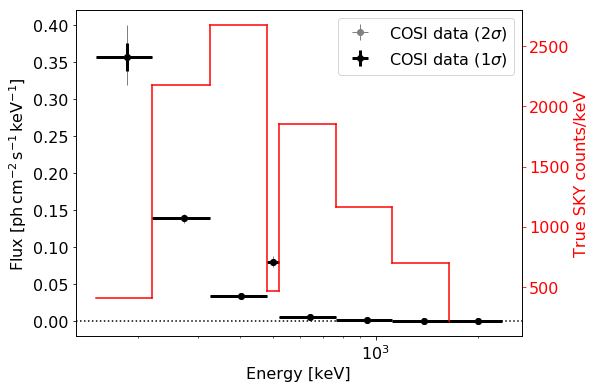

In [225]:
fig, ax = plt.subplots()

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err2[0:,:].T),#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($2\sigma$)')

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err[0:,:].T),#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=3,color='black',
             label=r'COSI data ($1\sigma$)')

ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

ax.axhline(0,linestyle=':')

#ax.set_yscale('log')
#ax.set_ylim(0,1e-1)
ax.legend()

#ax.set_ylim(-0.005,0.05)
lax_ylim = ax.get_ylim()

ax2 = plt.twinx()
"""
plt.step(analysis.dataset.energies.energy_bin_cen+2.5,
         np.sum(sky_data.dataset.binned_data,axis=(0,2,3))/analysis.dataset.energies.energy_bin_wid/2,
         where='mid',color='red')"""

sim_sky_rate = np.sum(sky_data.dataset.binned_data,axis=(0,2,3))#/analysis.dataset.energies.energy_bin_wid/2

for i in range(analysis.dataset.energies.n_energy_bins-1):
    ax2.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate[i],2),'r-')
    if ((i >= 0) & (i<analysis.dataset.energies.n_energy_bins-1)):
        ax2.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate[i],
                  sim_sky_rate[i+1]],'r-')

ax2.set_ylabel('True SKY counts/keV',color='red')

ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

rax_ylim = ax2.get_ylim()

#ax2.set_ylim(rax_ylim[0]*np.diff(lax_ylim)/(result.diff_flux[0:]/analysis.dataset.energies.energy_bin_wid[0:]/2).max(),
#             rax_ylim[0]+rax_ylim[1]*lax_ylim[1]/(result.diff_flux[0:]/analysis.dataset.energies.energy_bin_wid[0:]/2).max())

ax2.set_xscale('log')
#ax2.set_yscale('log')
#plt.ylim()

In [226]:
sky_data.dataset.times.times_wid

array([30334.51974058])

(0, 21.794642857142858)

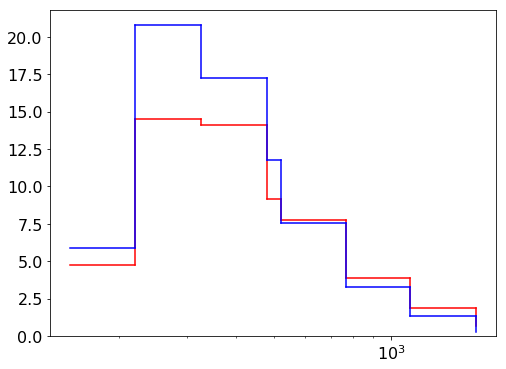

In [289]:
fac = 100**3.5#000*sky_data.dataset.times.times_wid

for i in range(rsp.n_e-3):
    plt.plot([rsp.e_min[i],
              rsp.e_min[i+1]],
             np.repeat(plaw_folded_counts[i],2)*fac,'r-')
    if ((i >= 0) & (i<rsp.n_e-3)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts[i]*fac,
                  plaw_folded_counts[i+1]*fac],'r-')
        

plt.xscale('log')
#plt.yscale('log')

sim_sky_rate = np.sum(sky_data.dataset.binned_data,axis=(0,2,3))/analysis.dataset.energies.energy_bin_wid/2

for i in range(analysis.dataset.energies.n_energy_bins-1):
    plt.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate[i],2),'b-')
    if ((i >= 0) & (i<analysis.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate[i],
                  sim_sky_rate[i+1]],'b-')

ax2.set_ylabel('True SKY counts/keV',color='red')

plt.ylim(0,)

In [ ]:
use_rsp = [find_nearest(rsp.e_cen,erg) for erg in analysis.dataset.energies.energy_bin_cen]

In [ ]:
use_rsp

In [ ]:
result.diff_flux# * (analysis.dataset.energies.energy_bin_wid*2) / rsp.e_wid[use_rsp]

In [ ]:
rsp.e_edges[use_rsp]

In [ ]:
analysis.dataset.energies.energy_bin_wid*2

In [ ]:
analysis.dataset.energies.energy_bin_wid*2 / rsp.e_wid[use_rsp]

In [ ]:
rsp.e_wid

In [ ]:
analysis.dataset.energies.energy_bin_cen

In [ ]:
result.diff_flux * (analysis.dataset.energies.energy_bin_wid*2) / rsp.e_wid[use_rsp]

In [ ]:
result.diff_flux[3]/1e-3#/(analysis.dataset.energies.energy_bin_wid*2)

In [ ]:
np.max(np.abs(result.diff_flux_err),axis=1) * (analysis.dataset.energies.energy_bin_wid*2) / rsp.e_wid[use_rsp]

In [ ]:
2*np.pi

In [ ]:
result.diff_flux * rsp.e_wid[use_rsp] / (analysis.dataset.energies.energy_bin_wid*2)**3

In [ ]:
result.diff_flux * (analysis.dataset.energies.energy_bin_wid*2)**2 / rsp.e_wid[use_rsp]

In [ ]:
180/np.pi

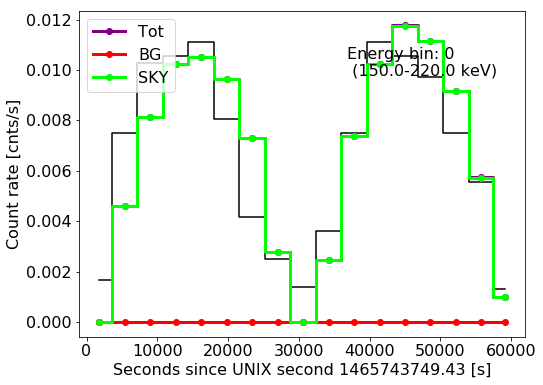

In [141]:
b = 0

analysis.dataset.plot_lightcurve(b)

#plt.twinx()

plt.step(analysis.dataset.times.times_cen,
         np.median(result.fit_pars[b]['model_tot'],axis=0)/(analysis.dataset.times.times_wid*2),
         color='purple',where='mid',marker='o',linewidth=3,label='Tot')

plt.step(analysis.dataset.times.times_cen,
         np.median(result.fit_pars[b]['model_bg'],axis=0)/(analysis.dataset.times.times_wid*2),
         color='red',where='mid',marker='o',linewidth=3,label='BG')

plt.step(analysis.dataset.times.times_cen,
         np.median(result.fit_pars[b]['model_sky'],axis=(0,1))/(analysis.dataset.times.times_wid*2),
         color='lime',where='mid',marker='o',linewidth=3,label='SKY')

plt.legend(loc=2)

#plt.plot(analysis.dataset.times.times_max[0::2],
#         np.median(result.fit_pars[b]['Abg'],axis=0),color='red')
#plt.plot(analysis.dataset.times.times_cen,
#         np.sum(rsp.sky_response[b],axis=1),color='lime')

In [ ]:
break

In [ ]:
tmp = np.sum(rsp.rsp.response_grid_normed[:,:,:,:,:,:],axis=(0,1,2,3))

In [ ]:
rsp_e_edges = np.array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000])

In [ ]:
rsp_e_edges.shape

In [ ]:
plt.pcolormesh(rsp_e_edges,rsp_e_edges,tmp.T/np.diff(rsp_e_edges)**2,
              cmap=plt.cm.plasma)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
#plt.xlim(100,5000)
#plt.ylim(100,5000)

In [ ]:
def Gaussian(energy,p):
    """
    Returns:
    Differential flux shaped as symmetric Gaussian "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (area under Gaussian) (in ph/cm2/s)
    :param p:      p[1] = Line centroid (in keV)
    :param p:      p[2] = Line width (1-sigma value) (in keV)
    """    

    return p[0]/(np.sqrt(2*np.pi)*p[2])*np.exp(-(energy-p[1])**2/(2*p[2]**2))

In [ ]:
def powerlaw(energy, p):
    """
    Returns:
    Differential flux shaped as power-law function "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (in ph/cm2/s/keV)
    :param p:      p[1] = Power-law index (unitless)

    Misc:
    E0             Pivotal energy, i.e. where the power-law is normalised at (in keV)
    """
    
    E0 = 100.
    
    return p[0]*np.power(energy/E0,p[1])

In [ ]:
# integral of the differential flux
# here, we use Simpson's 3/8 rule as it provides very accurate on this scale;
# if, however, the models can change abruptly, consider the true integral, if available

def integrate_gaussian(e_lo,e_hi,p):
    return (e_hi-e_lo)/6.0*(Gaussian(e_lo,p)+4*Gaussian((e_hi+e_lo)/2.0,p)+Gaussian(e_hi,p))

def integrate_powerlaw(e_lo,e_hi,p):
    return (e_hi-e_lo)/6.0*(powerlaw(e_lo,p)+4*powerlaw((e_hi+e_lo)/2.0,p)+powerlaw(e_hi,p))

In [ ]:
plt.plot(rsp.e_cen,Gaussian(rsp.e_cen,[1e-2,511,1]))

In [ ]:
gaussian_true_fluxes = integrate_gaussian(rsp.e_min, rsp.e_max, (1e-2,511,0.1))  # dNp/(dt dA) 

In [ ]:
gaussian_true_fluxes = integrate_gaussian(analysis.dataset.energies.energy_bin_min,
                                          analysis.dataset.energies.energy_bin_max, (1e-2,511,10))/\
(analysis.dataset.energies.energy_bin_wid/2)**0

for i in range(analysis.dataset.energies.n_energy_bins-1):
    plt.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(gaussian_true_fluxes[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [gaussian_true_fluxes[i],
                  gaussian_true_fluxes[i+1]],'r-')

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err2[0:,:].T),#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($2\sigma$)')

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err[0:,:].T),#|/analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=3,color='black',
             label=r'COSI data ($1\sigma$)')

ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

ax.axhline(0,linestyle=':')

#ax.set_yscale('log')

ax.legend()

#ax.set_xlim(150,650)
#ax.set_ylim(0,1e-1)

gaussian_true_fluxes = integrate_gaussian(analysis.dataset.energies.energy_bin_min,
                                          analysis.dataset.energies.energy_bin_max, (1e-2,511,0.1))/analysis.dataset.energies.energy_bin_wid/2

for i in range(analysis.dataset.energies.n_energy_bins-1):
    ax.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(gaussian_true_fluxes[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        ax.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [gaussian_true_fluxes[i],
                  gaussian_true_fluxes[i+1]],'r-')

#ax.step(rsp.e_cen,gaussian_true_fluxes)

In [ ]:
gaussian_true_fluxes

In [ ]:
rsp.e_cen

In [ ]:
gaussian_folded_counts = np.dot(gaussian_true_fluxes, tmp)#*3600 / rsp.e_wid

In [ ]:
plt.plot(rsp.e_cen,gaussian_folded_counts)

In [ ]:
result.fit_pars[4]['model_values'].shape

In [ ]:
plt.plot(np.sum(analysis.dataset.binned_data[:,4,:,:].reshape(24,30*1145)[:,background.calc_this[4]].ravel().reshape(24,len(background.calc_this[4])),axis=0))
plt.plot(np.sum(np.median(result.fit_pars[4]['model_values'],axis=0).reshape(24,len(background.calc_this[4])),axis=0))

In [ ]:
73464/24

In [ ]:
np.median(result.fit_pars[4]['model_tot'],axis=0)/(analysis.dataset.times.times_wid*2)

In [ ]:
analysis.dataset.times.times_wid

In [ ]:
np.median(result.fit_pars[b]['flux'],axis=0)

In [ ]:
sky_data.dataset.binned_data.shape

In [ ]:
plt.plot(analysis.dataset.times.times_cen[::2],
         np.median(result.fit_pars[3]['Abg'],axis=0))